In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gaitFunctions
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Load Data

In [8]:
excel_file = 'all_exemplaris_2024-07-29.xlsx'
path_summaries_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
path_summaries_df.head(2)

,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec,Original Video Length (sec),Body Lengths Traveled
0,ea_19mar_tardigrade38_exemplaris,exemplaris,tardigrade38,19mar,956.03,0.020003,0.277488,0.100721,0.362974,67.9678,...,0.228128,2477.934667,36.457479,21.454283,16,0.235406,13,0.191267,125.935484,13.419032
1,ea_19mar_tardigrade39_exemplaris,exemplaris,tardigrade39,19mar,956.03,0.016064,0.246613,0.090188,0.365707,96.5807,...,0.174381,3616.831000,37.448797,17.959342,30,0.310621,14,0.144956,153.612903,13.935291


In [9]:
# convert mm to micrometers
path_summaries_df['Body Size (µm^2)'] = path_summaries_df['Body Size (mm^2)'].values * 1000 * 1000
path_summaries_df['Body Length (µm)'] = path_summaries_df['Body Length (mm)'].values * 1000
path_summaries_df['Body Width (µm)'] = path_summaries_df['Body Width (mm)'].values * 1000
path_summaries_df['Speed (µm/sec)'] = path_summaries_df['Speed (mm/sec)'].values * 1000
path_summaries_df['Speed (µm/sec cruising)'] = path_summaries_df['Speed (mm/sec cruising)'].values * 1000

In [10]:
columns_to_analyze = [
    'Original Video Length (sec)', 
#     'Duration analyzed (sec)',
    'Body Size (µm^2)',
    'Body Length (µm)',
    'Body Width (µm)', 
    'Body Width/Length Ratio', 
    'Distance traveled (mm)', 
    'Body Lengths Traveled',
    'Percentage of time cruising',
    'Speed (µm/sec)',
    'Speed (body lengths / sec)', 
    'Speed (µm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
    #'Total bearing change (deg)', 
    'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
    #'Number of stops', 
    'Stops / sec',
    #'Number of turns', 
    'Turns / sec'
]
print(len(columns_to_analyze))

16


In [11]:
# clean up column names
collablist = [
    'Original Video Length (sec)', 
#     'Duration analyzed (sec)',
    'Body Size (µm^2)',
    'Body Length (µm)',
    'Body Width (µm)', 
    'Body Width/Length Ratio', 
    'Distance traveled (mm)', 
    'Body Lengths Traveled',
    '% sustained walking',
    'Speed (µm/sec)',
    'Speed (body lengths / sec)', 
    'Speed (µm/sec walking)', 
    'Speed (body lengths / sec walking)',
    #'Total bearing change (deg)', 
    'Bearing change (deg) / sec',
    'Bearing change (deg) / sec walking', 
    #'Number of stops', 
    'Stops / sec',
    #'Number of turns', 
    'Turns / sec'
]

collabs = dict(zip(columns_to_analyze,collablist))
# be sure we have the right labels
for k in collabs.keys():
    print(k, '-->', collabs[k])

Original Video Length (sec) --> Original Video Length (sec)
Body Size (µm^2) --> Body Size (µm^2)
Body Length (µm) --> Body Length (µm)
Body Width (µm) --> Body Width (µm)
Body Width/Length Ratio --> Body Width/Length Ratio
Distance traveled (mm) --> Distance traveled (mm)
Body Lengths Traveled --> Body Lengths Traveled
Percentage of time cruising --> % sustained walking
Speed (µm/sec) --> Speed (µm/sec)
Speed (body lengths / sec) --> Speed (body lengths / sec)
Speed (µm/sec cruising) --> Speed (µm/sec walking)
Speed (body lengths / sec cruising) --> Speed (body lengths / sec walking)
Bearing change (deg) / sec --> Bearing change (deg) / sec
Bearing change (deg) / sec cruising --> Bearing change (deg) / sec walking
Stops / sec --> Stops / sec
Turns / sec --> Turns / sec


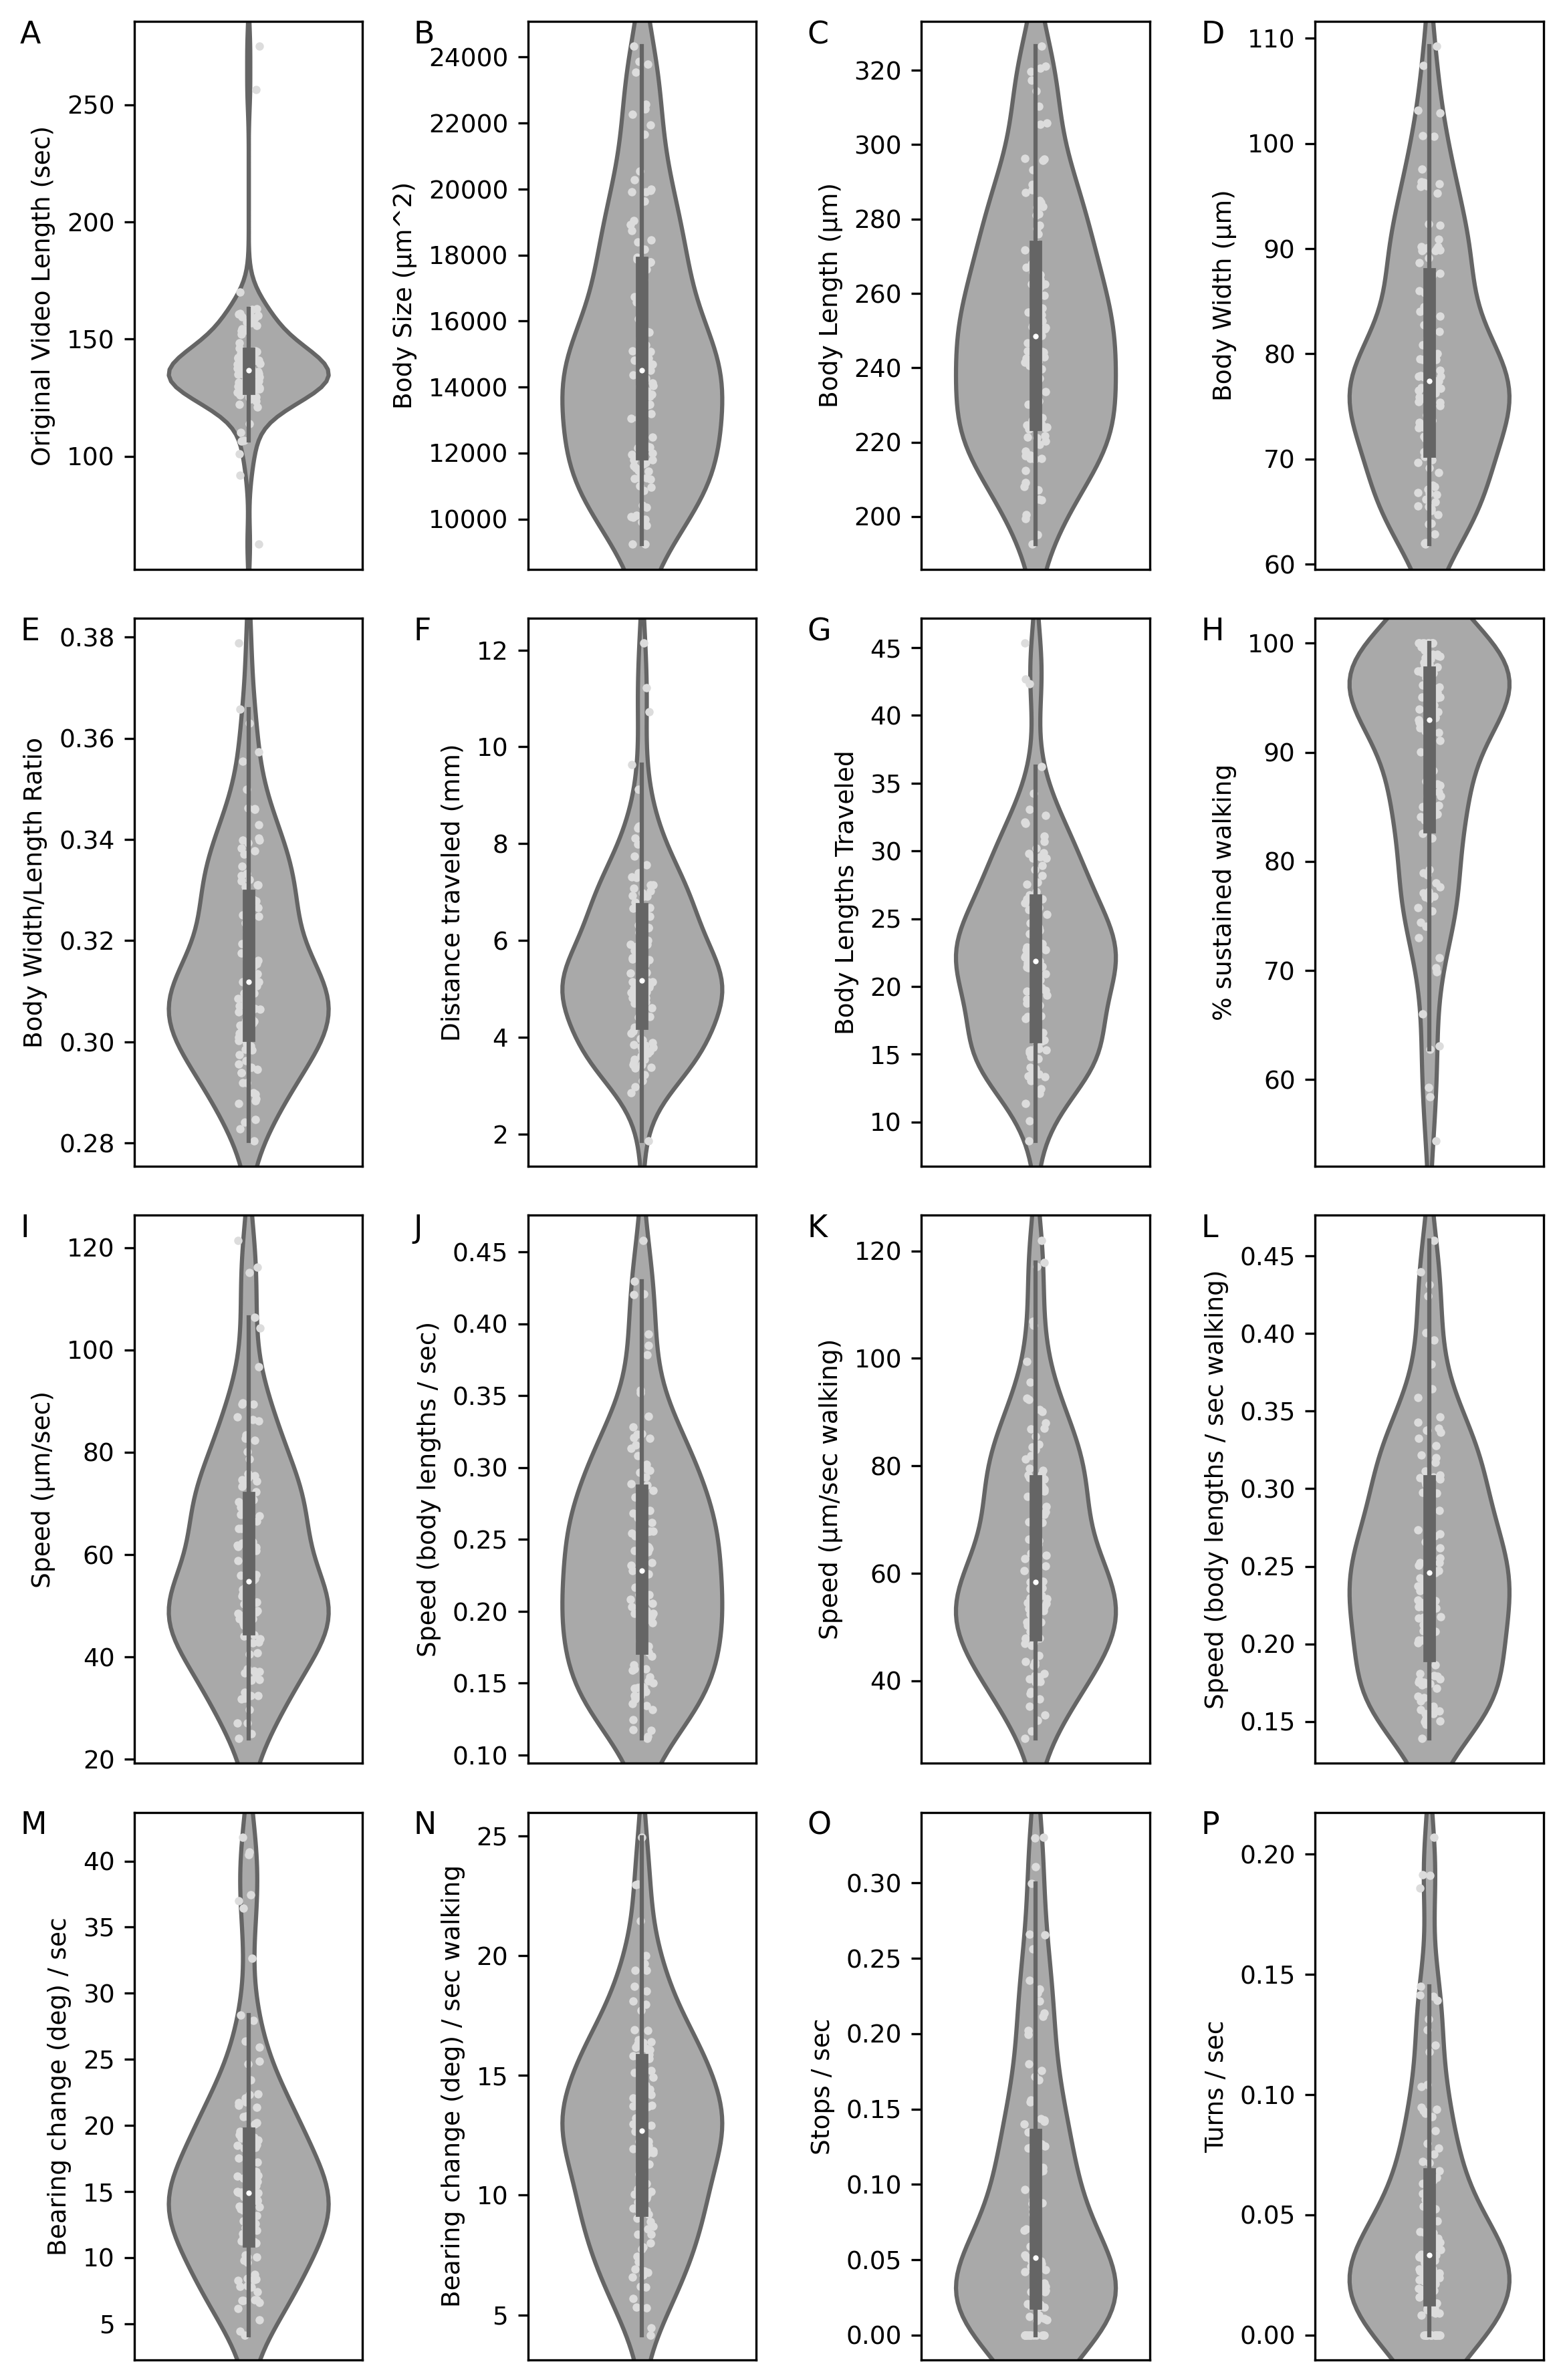

In [12]:
rows,cols = [4,4]
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
f,axes = plt.subplots(rows,cols,figsize = (8,12), dpi=300)
axes_list = axes.reshape(1,len(columns_to_analyze))[0]

for i, col in enumerate(columns_to_analyze):
    axes_list[i] = gaitFunctions.singleViolinPoints(axes_list[i], path_summaries_df, col, 
                                                    box=True, vwidth=0.7, #medsize=5, # medsize is not working!
                                                    vcolor='darkgray',pointcolor='gainsboro')
    axes_list[i].set_ylabel(collabs[col])
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes_list[i].annotate(letters[i], xy=(-0.5, 0.96), xycoords='axes fraction', fontsize=axis_fontsize)
    
plt.tight_layout()
plt.show()

In [9]:
# # Save table as an excel file ... 
# out_file = 'whole-body_movement.xlsx'
# with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
#     summary_df[['Measurement','Mean ± Std']].to_excel(writer, index=False, sheet_name='whole-body movement')

# Figure 1 (and S01)

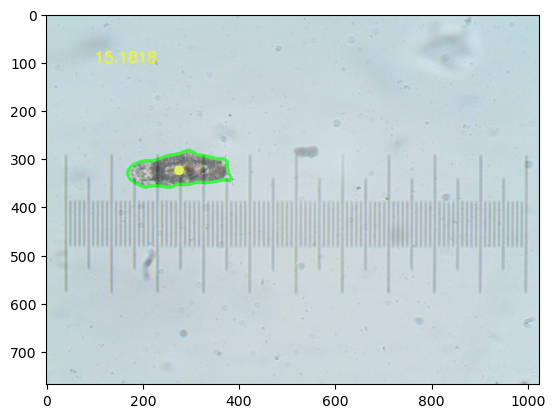

In [13]:
tardigrade = plt.imread('01_videoframe.png')
micro = plt.imread('01_micrometer.png')
# superimpose!
im = cv2.addWeighted(tardigrade, 0.7, micro, 0.3, 0)
plt.imshow(im)
plt.show()

[4.  2.6]


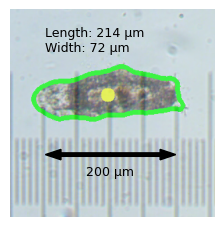

In [14]:
def tardigradeSize(ax,im):

    import matplotlib.patches as mpatches
    from matplotlib import colormaps as cm

    im_cropped = im[150:600,:] # if labeled time and whole micrometer
    # im_cropped = im[150:425,150:400]  # if just length and width

    arrow_x = 280
    arrow_y = 260
    arrow_width = 5
    dx = 94
    dy = 0

    # text for size and for scalebar
    ax.text(arrow_x - dx,110,'Length: 214 µm\nWidth: 72 µm', color='k', fontsize=tick_fontsize)
    ax.text(arrow_x-36, arrow_y+30, '200 µm', color='k', fontsize=tick_fontsize)

    # arrow for scalebar
    arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, dy,
                                width=arrow_width, length_includes_head=True, color='k')
    ax.add_patch(arrow_right)
    arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, dy,
                                width=arrow_width, length_includes_head=True, color='k')
    ax.add_patch(arrow_left)

    ax.axis('off')
    ax.set_xlim([135,430]) # if include whole micrometer and tracked path
    ax.set_ylim([350,50])
    ax.imshow(im_cropped)
    return ax

f=plt.figure(figsize=(4,2.6))
ax=f.add_axes([0.1,0.1,0.8,0.8])

ax = tardigradeSize(ax,im)
print(f.get_size_inches())
plt.show()

In [15]:
def scat(ax,x,y,xlab,ylab):
    r,p = stats.spearmanr(x,y)
    if p < 0.05:
        sns.regplot(ax=ax, x=x, y=y, scatter_kws={'s':marker_size,'color':marker_color}, 
                    line_kws={'color':marker_color,'linewidth':2})
    else:
        ax.scatter(x,y,s=marker_size,alpha=marker_alpha,color=marker_color)
    print('Raw p',p)
    print(xlab + ' vs. ' + ylab + ' ρ = ' + str(np.round(r,3)) +  ', p = ', str(np.round(p,3)))
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    print('n = ' + str(len(x)))
    return ax

Raw p 2.235408064559326e-39
Body Length (µm) vs. Body Width (µm) ρ = 0.905, p =  0.0
n = 103


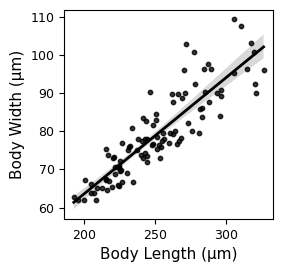

In [16]:
lengths = path_summaries_df['Body Length (mm)'].values*1000
widths = path_summaries_df['Body Width (mm)'].values*1000
xlab = 'Body Length (µm)'
ylab ='Body Width (µm)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,lengths,widths,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

... getting first frame ...
... getting last frame ...
Last successful frame = 503


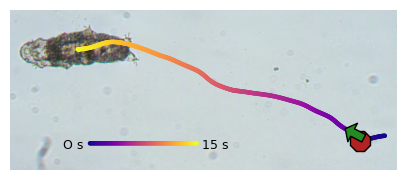

In [17]:
'''Track with Stop & Turn points'''
def trackingExample(ax,im,addSt3opsTurns=True):
    cmap_name = 'plasma'
    cmap = mpl.colormaps.get_cmap(cmap_name)

    # add color bar for timeline on separate axis
    # ax_colorbar = f.add_axes([0.9,0.2,0.02,0.6])   
    # norm = mpl.colors.Normalize(vmin=0, vmax=tracked_df.times.values[-1])
    # plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Time (sec)', cax = ax_colorbar)

    # add fake color bar for timeline
    time_x = 300
    time_dx = 200
    time_y = 500
    num_points = 100
    cols = cmap(np.linspace(0,1,num_points))
    ax.scatter(np.linspace(time_x,time_x+time_dx,num_points),[time_y]*num_points, c=cols, s=5)
    ax.text(time_x-50, time_y+10, 'O s', fontsize=tick_fontsize)
    ax.text(time_x+time_dx+10, time_y+10, '15 s', fontsize=tick_fontsize)

    # plot image of tardigrade
    # combined_frame = gaitFunctions.superImposedFirstLast(movie_file)
    # combined_frame = combined_frame
    first_frame, last_frame = gaitFunctions.getFirstLastFrames(movie_file)
    frame_to_show = last_frame
    frame_to_show = frame_to_show[:, :, [2, 1, 0]]
    ax.imshow(frame_to_show) # combined_frame or last_frame

    # plot tardigrade path
    xcoords = tracked_df.xcoords.values
    ycoords = tracked_df.ycoords.values
    smoothedx = tracked_df.smoothed_x.values
    smoothedy = tracked_df.smoothed_y.values
    cols = cmap(np.linspace(0,1,len(smoothedx)))
    # ax.scatter(xcoords, ycoords, c = 'grey', s=20) # raw data 'dimgrey' or 'black' or 'slategray'
    ax.scatter(smoothedx, smoothedy, c = cols, s=5) # smoothed data

    # add stops and turns
    if addStopsTurns:

        arrowup, arrowdown, cut_arrowup, cut_arrowdown = gaitFunctions.getArrowMarkers()
        markersize = 15
        stop_color = 'firebrick' # 'tab:red' or 'firebrick'
        turn_color = 'forestgreen' # 'limegreen' or 'tab:green' or 'green' or 'forestgreen'

        # get runs of stops ... the stop marker will be plotted in the beginning of the stop bout
        stops = tracked_df.stops.values
        stop_bouts = gaitFunctions.one_runs(stops)
        # stop_indices = [int((x[0]+x[1])/2) for x in stop_bouts] #  at middle of bout
        stop_indices = [x[0] for x in stop_bouts] # at beginning of bout
        stop_x = [smoothedx[i] for i in stop_indices]
        stop_y = [smoothedy[i] for i in stop_indices]

        # plot stops
        ax.plot(stop_x, stop_y, "8", markersize=markersize, markerfacecolor=stop_color, markeredgecolor="k")

        # get turns ... the turn marker will be plotted at the END of the turn
        turns = tracked_df.turns.values
        turn_bouts = gaitFunctions.one_runs(turns)
        turn_indices = [x[1] for x in turn_bouts]

        turn_x = [smoothedx[i] for i in turn_indices]
        turn_y = [smoothedy[i] for i in turn_indices]

        turn_directions = np.zeros(len(turn_bouts))
        for i, idx in enumerate(turn_indices):
            try:
                turn_directions[i] = np.mean(tracked_df.filtered_bearings.values[idx:idx+5])
            except:
                turn_directions[i] = tracked_df.filtered_bearings.values[idx]

        # plot turns
        for i, angle in enumerate(turn_directions):
            t = mpl.markers.MarkerStyle(marker=arrowup)
            t._transform = t.get_transform().rotate_deg(-angle)
            ax.plot(turn_x[i], turn_y[i], marker=t, markersize=markersize, markerfacecolor=turn_color, markeredgecolor="k")

    ax.set_ylim([550,250])
    ax.set_xlim([150,875])
    ax.axis('off')

    return ax
        
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_tardiGait_paper/analyses_summaries/02 tracking_path')
excel_filename = 'iw_30Jan_tardigrade01_exemplaris_037-058.xlsx'
movie_file = 'iw_30Jan_tardigrade01_exemplaris_037-058.mov'
tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)

f = plt.figure(figsize=(5,2))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
addStopsTurns = True
ax = trackingExample(ax,im,addStopsTurns)
plt.show()

Percentage Sustained Walking = 91.0


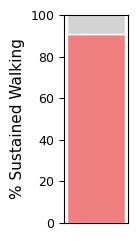

In [18]:
def cruise(ax, tracked_df):
    
    stops = tracked_df.stops.values
    turns = tracked_df.turns.values
    
    non_cruising_proportion = np.count_nonzero(stops + turns) / len(stops)
    cruising_proportion = 1 - non_cruising_proportion
    
    cruising_percentage = cruising_proportion * 100
    non_cruising_percentage = 100-cruising_percentage
    
    print('Percentage Sustained Walking = ' + str(np.round(cruising_percentage,1)))
    
    cruising_color = 'lightcoral'
    
    ax.set_ylabel('% Sustained Walking', color = 'black')# cruising_color)
    ax.bar(1, cruising_percentage, bottom = 0, 
           color = cruising_color, edgecolor = 'white', width = 0.5)
    ax.bar(1, non_cruising_percentage, bottom = cruising_percentage,
           color = 'lightgray', edgecolor = 'white', width = 0.5)
    
    ax.set_xticks([])
    ax.set_ylim([0,100])
    
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    
    return ax


f=plt.figure(figsize=(0.8,2.6))
cruisingax = f.add_axes([0.1, 0.1, 0.8, 0.8])
cruisingax=cruise(cruisingax, tracked_df)
plt.show()

Raw p 0.00011403055282636744
Body Length (µm) vs. Cruising Speed
(µm/sec) ρ = 0.371, p =  0.0
n = 103


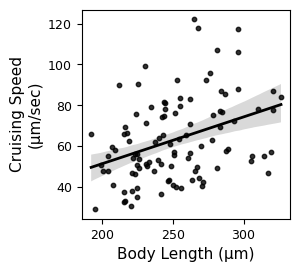

In [19]:
'''length vs. speed'''
lengths = path_summaries_df['Body Length (µm)'].values
cruising_speed_mm = path_summaries_df['Speed (µm/sec cruising)'].values
xlab = 'Body Length (µm)'
ylab ='Cruising Speed\n(µm/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,lengths,cruising_speed_mm,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Raw p 0.00039492590743541665
Body Size (µm$^2$) vs. Cruising Speed
(µm/sec) ρ = 0.343, p =  0.0
n = 103


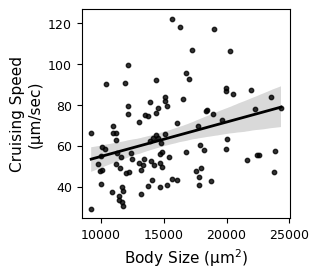

In [20]:
'''Area vs Speed'''
areas = path_summaries_df['Body Size (µm^2)'].values
cruising_speed_mm = path_summaries_df['Speed (µm/sec cruising)'].values
xlab = 'Body Size (µm$^2$)'
ylab = 'Cruising Speed\n(µm/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,areas,cruising_speed_mm,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Raw p 0.7694037370132115
Body Size (µm$^2$) vs. Cruising Speed
(bodylength/sec) ρ = -0.029, p =  0.769
n = 103


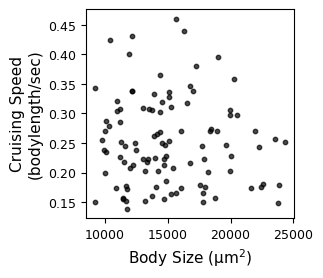

In [21]:
'''Area vs Normalized Speed'''
areas = path_summaries_df['Body Size (µm^2)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values
xlab = 'Body Size (µm$^2$)'
ylab = 'Cruising Speed\n(bodylength/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,areas,cruising_speed_bodylength,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Raw p 0.9797090608208162
Body Length (µm) vs. Cruising Speed
(bodylength/sec) ρ = -0.003, p =  0.98
n = 103


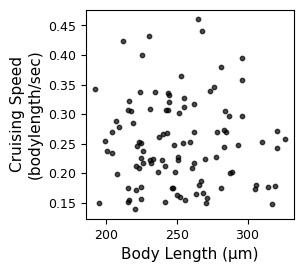

In [22]:
'''Length vs. Normalized speed'''
lengths = path_summaries_df['Body Length (µm)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values
xlab = 'Body Length (µm)'
ylab = 'Cruising Speed\n(bodylength/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,lengths,cruising_speed_bodylength,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Raw p 0.00013061994919423371
Width:Length Ratio vs. Cruising Speed
(bodylength/sec) ρ = -0.368, p =  0.0
n = 103


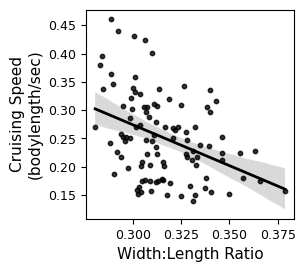

In [23]:
'''width:length ratio vs. Normalized speed '''
ratios = path_summaries_df['Body Width/Length Ratio'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values
xlab = 'Width:Length Ratio'
ylab = 'Cruising Speed\n(bodylength/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,ratios,cruising_speed_bodylength,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

# All of Figure 01

Raw p 2.235408064559326e-39
Body Length (µm) vs. Body Width (µm) ρ = 0.905, p =  0.0
n = 103
... getting first frame ...
... getting last frame ...
Last successful frame = 503
Percentage Sustained Walking = 91.0
Raw p 0.9797090608208162
Body Length (µm) vs. Walking Speed
(bodylength/sec) ρ = -0.003, p =  0.98
n = 103
Raw p 0.00013061994919423371
Width:Length Ratio vs. Walking Speed
(bodylength/sec) ρ = -0.368, p =  0.0
n = 103


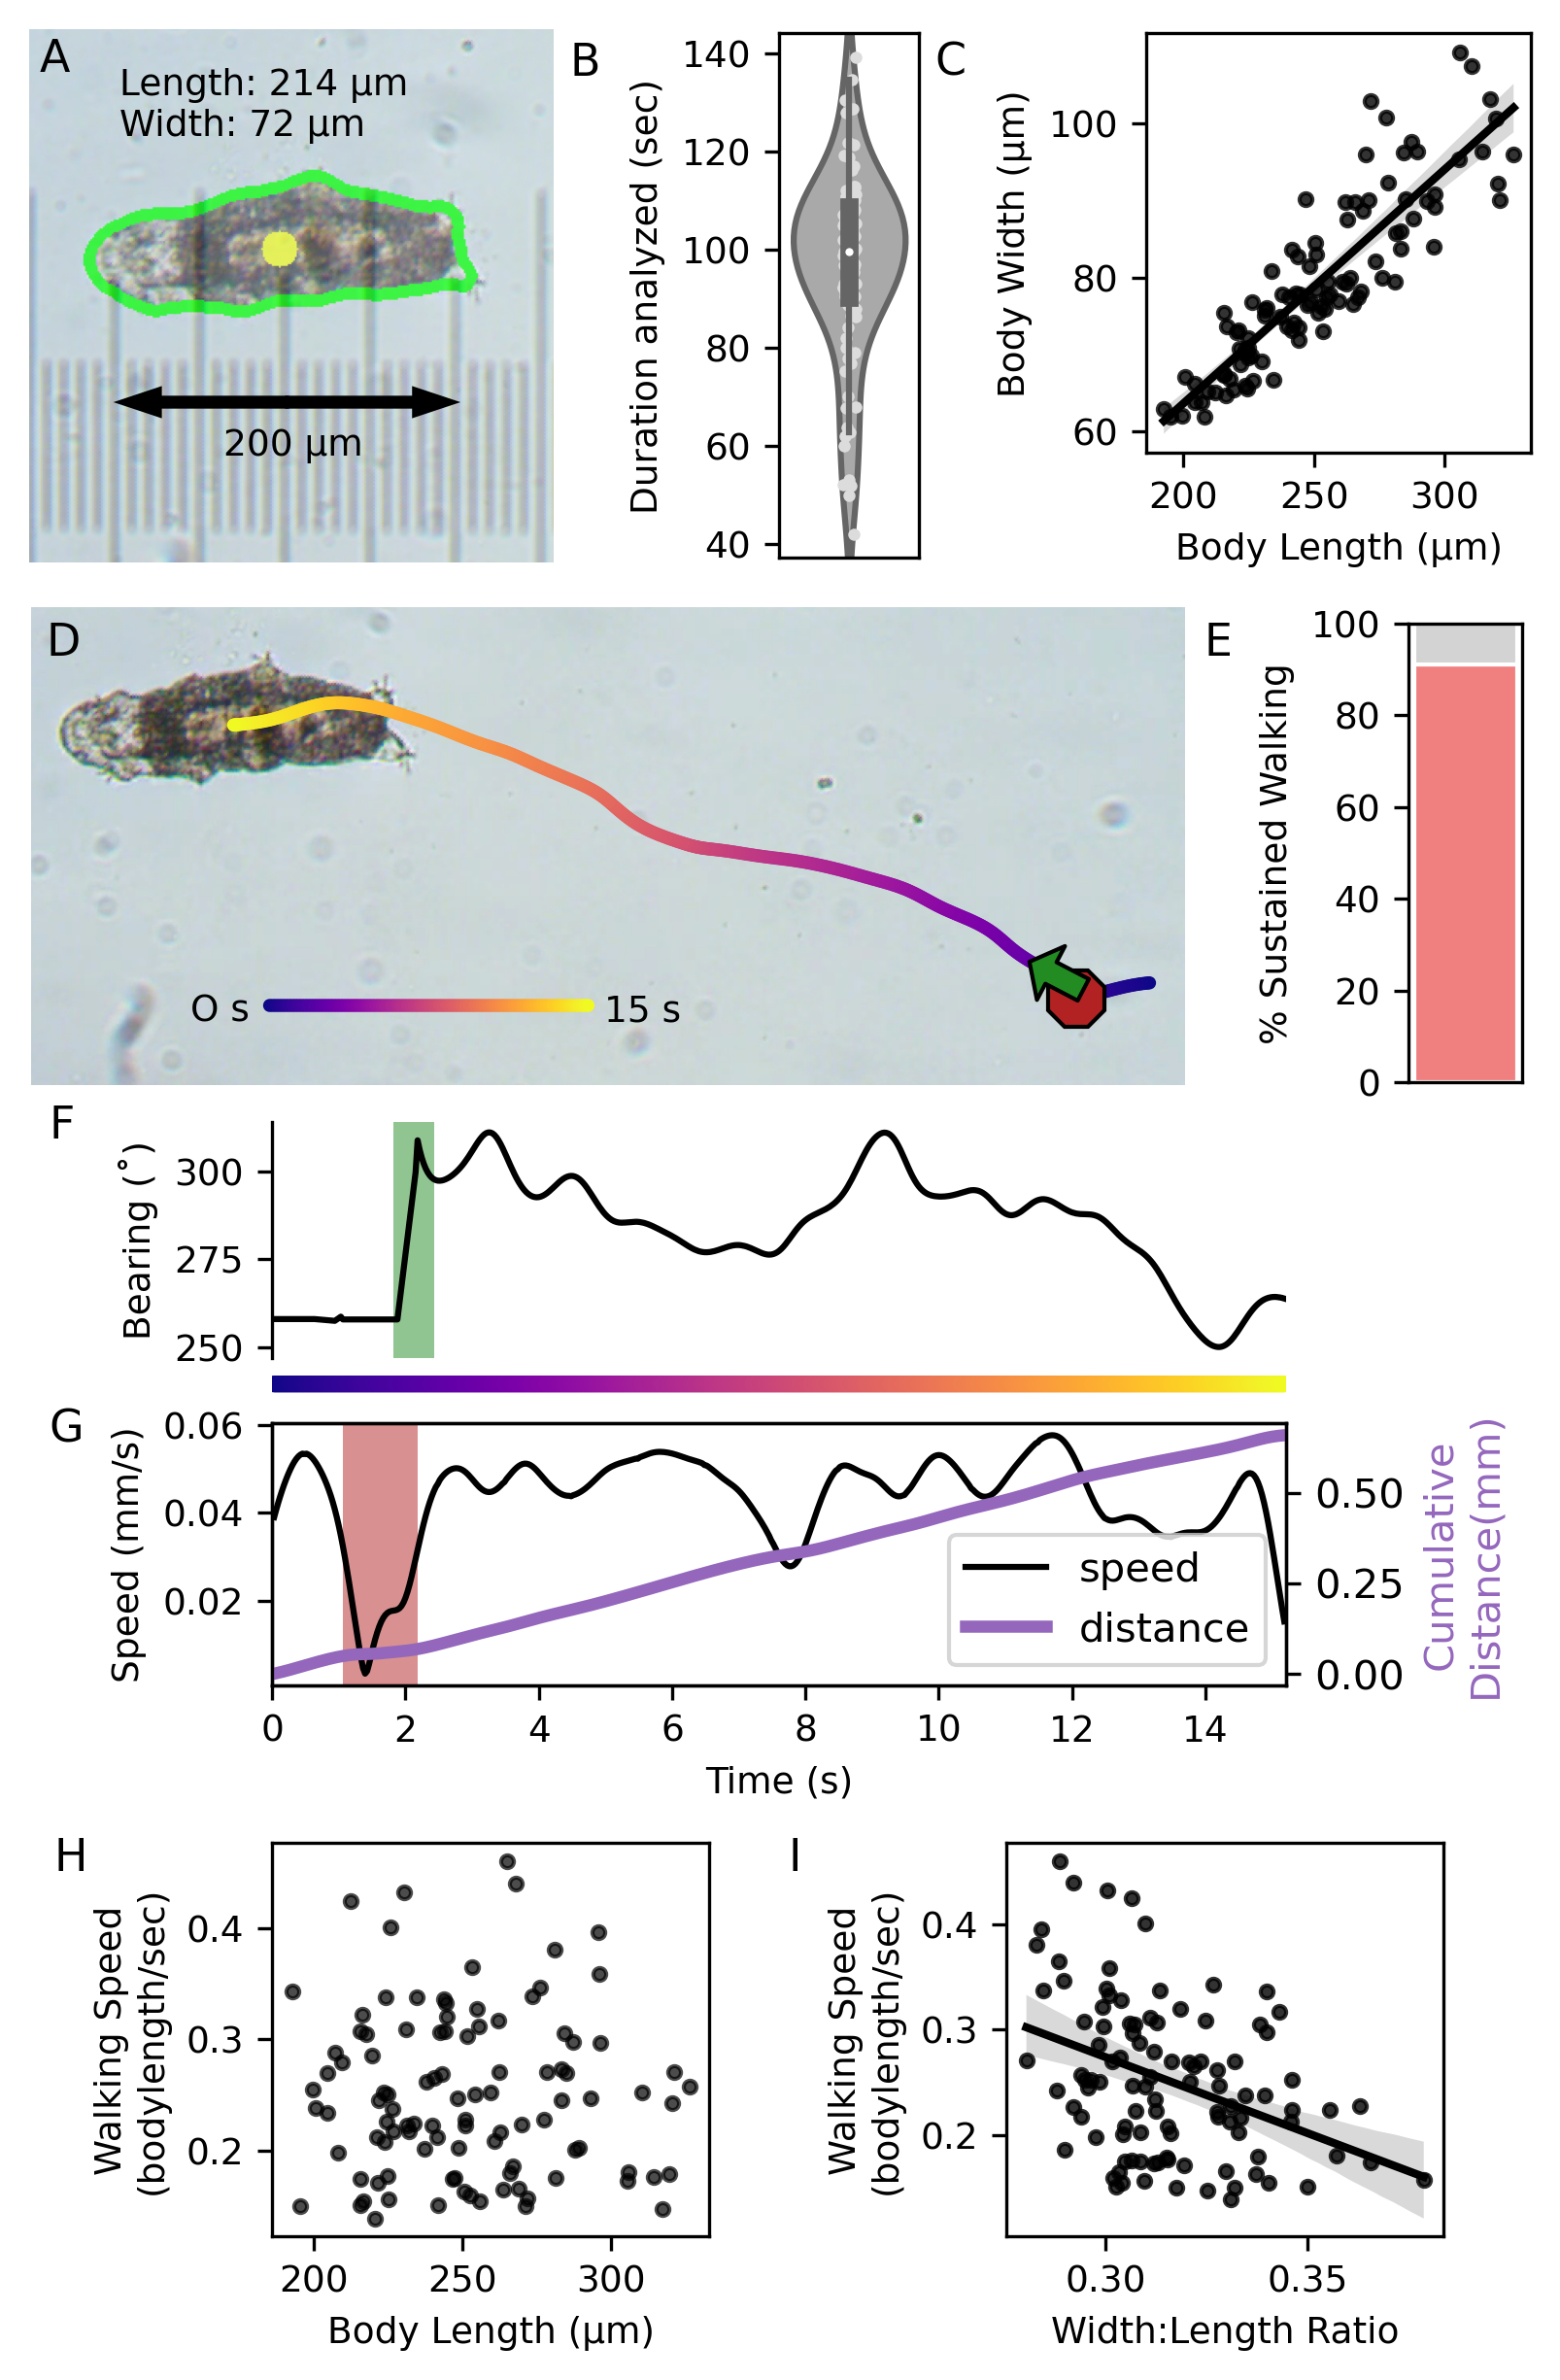

In [24]:
f = plt.figure(figsize=(6,9),dpi=300)
tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)
path_stats = gaitFunctions.loadPathStats(movie_file)
scale = float(path_stats['scale'])
unit = path_stats['unit']
last_frame = tracked_df.times.values[-1]

# set up axes positions
size_ax = f.add_axes(     [0.061, 0.73,0.3,  0.22])
durations_ax = f.add_axes([0.49, 0.74,0.08, 0.20])
lw_ax = f.add_axes(       [0.7, 0.78,0.22, 0.16])

track_ax = f.add_axes(    [0.062,0.51,0.66, 0.24])
cruise_ax = f.add_axes(   [0.85, 0.54,0.065,0.175])

bearing_ax = f.add_axes(   [0.2, 0.435, 0.58, 0.09])
timeribbon_ax = f.add_axes([0.2, 0.38,  0.58, 0.09])
speed_ax = f.add_axes(     [0.2, 0.31,  0.58, 0.10])


nsvl_ax = f.add_axes(     [0.2, 0.1,0.25,0.15]) # scatter of length vs normalized speed
nsvr_ax = f.add_axes(     [0.62,0.1,0.25,0.15]) # scatter of width:length vs normalized speed

# show tardigrade with scale bar and size annotations
size_ax=tardigradeSize(size_ax,im)
size_ax.annotate('A', xy=(0.02, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

# box plot of durations analyzed
durations_ax = gaitFunctions.singleViolinPoints(durations_ax, 
                                           path_summaries_df, 
                                           'Duration analyzed (sec)', box=True,
                                               vcolor='darkgray',pointcolor='gainsboro')
durations_ax.annotate('B', xy=(-1.5, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

# scatter plot of length vs. width
lw_ax=scat(lw_ax,lengths,widths,'Body Length (µm)','Body Width (µm)')
lw_ax.annotate('C', xy=(-0.55, 0.90), xycoords='axes fraction', fontsize=axis_fontsize)

# tracking example
track_ax=trackingExample(track_ax,im,True)
track_ax.annotate('D', xy=(0.013, 0.90), xycoords='axes fraction', fontsize=axis_fontsize)

# percentage cruising
cruise_ax = cruise(cruise_ax, tracked_df)
cruise_ax.annotate('E', xy=(-1.8, 0.93), xycoords='axes fraction', fontsize=axis_fontsize)

# bearing change plot
bearing_ax = plotClip.bearingChangePlot(bearing_ax, tracked_df)
xlim = [0,last_frame]
bearing_ax.set_xlim(xlim)
bearing_ax.annotate('F', xy=(-0.22, 0.93), xycoords='axes fraction', fontsize=axis_fontsize)

# time ribbon plot
timeribbon_ax = plotClip.timeRibbonPlot(timeribbon_ax, tracked_df)
timeribbon_ax.axis('off')
timeribbon_ax.set_xlim(xlim)


# speed and cumulative distance plot
speed_ax, distax = plotClip.speedDistancePlot(speed_ax, tracked_df, scale, unit)
distax.yaxis.label.set_text('Cumulative\nDistance(mm)')
speed_ax.set_xlim(xlim)
speed_ax.annotate('G', xy=(-0.22, 0.93), xycoords='axes fraction', fontsize=axis_fontsize)

# scatter plots
nsvl_ax = scat(nsvl_ax,lengths,cruising_speed_bodylength,'Body Length (µm)','Walking Speed\n(bodylength/sec)')
nsvl_ax.annotate('H', xy=(-0.5, 0.93), xycoords='axes fraction', fontsize=axis_fontsize)
nsvr_ax = scat(nsvr_ax,ratios,cruising_speed_bodylength,'Width:Length Ratio','Walking Speed\n(bodylength/sec)')
nsvr_ax.annotate('I', xy=(-0.5, 0.93), xycoords='axes fraction', fontsize=axis_fontsize)

# adjust axis parameters
for ax in [size_ax, durations_ax, lw_ax, track_ax, cruise_ax, 
           bearing_ax, timeribbon_ax, speed_ax,  nsvl_ax, nsvr_ax]:
    ax.xaxis.label.set_size(tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.show()

# Supplemental Figure S1

Raw p 0.00011403055282636744
Body Length (µm) vs. Walking Speed
(µm/sec) ρ = 0.371, p =  0.0
n = 103
Raw p 0.00039492590743541665
Body Size (µm$^2$) vs. Walking Speed
(µm/sec) ρ = 0.343, p =  0.0
n = 103
Raw p 0.7694037370132115
Body Size (µm$^2$) vs. Walking Speed
(bodylength/sec) ρ = -0.029, p =  0.769
n = 103


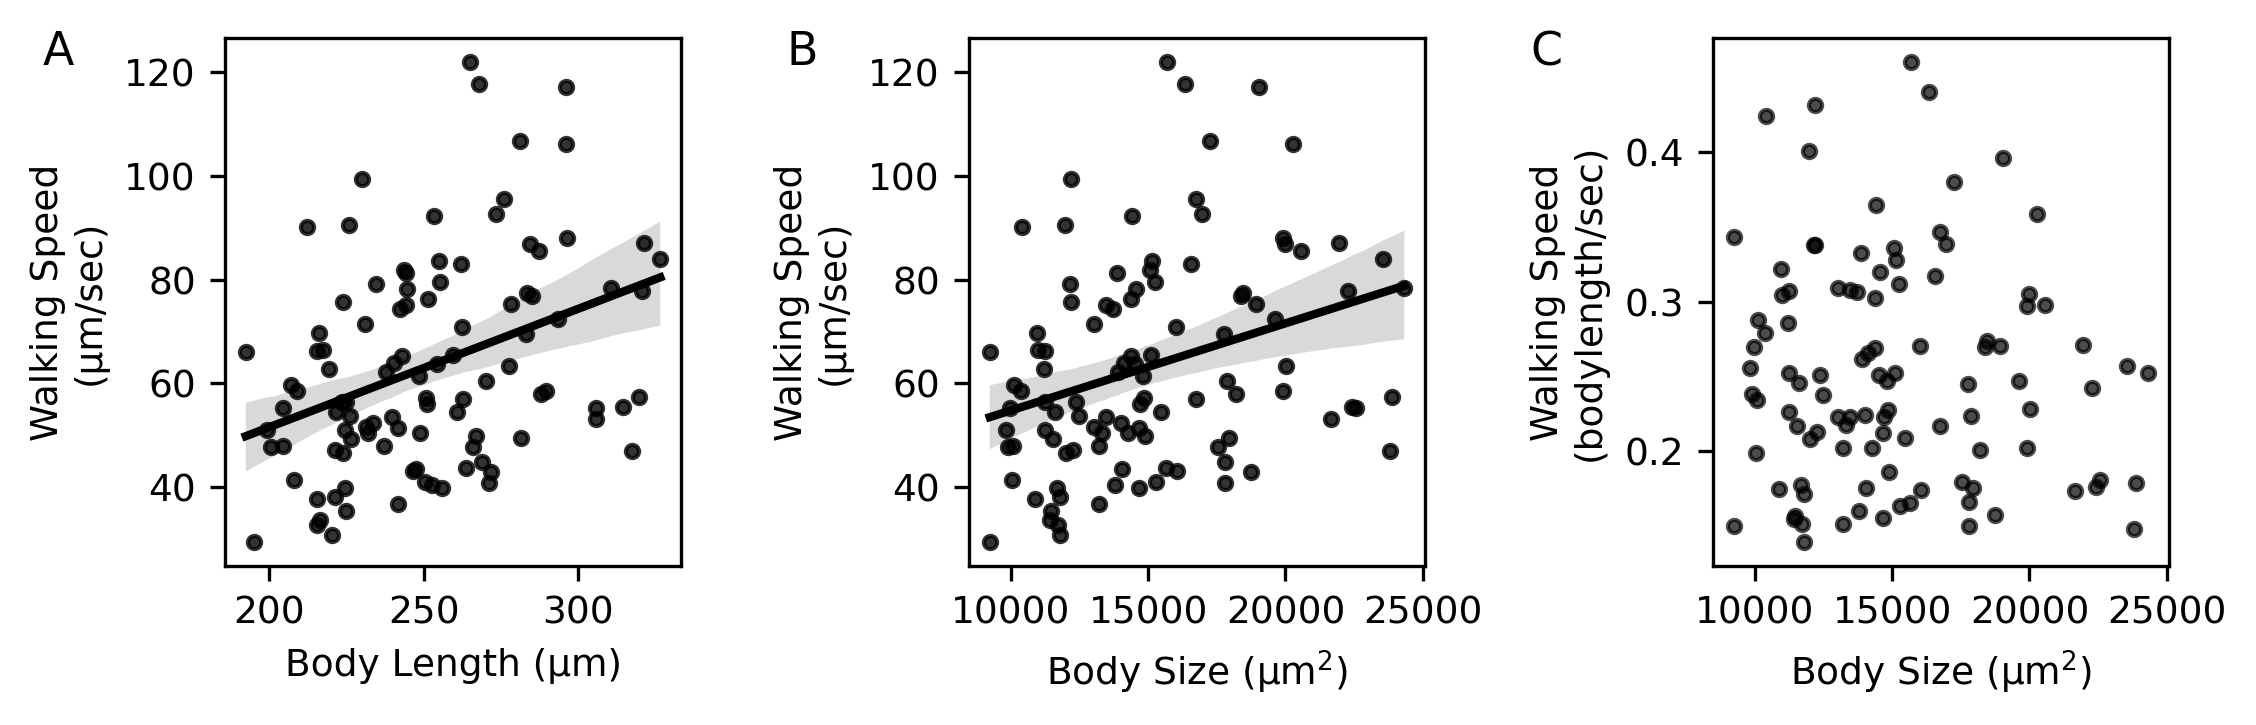

In [25]:
'''
supplemental fig 01
'''
f=plt.figure(figsize=(8,2.2),dpi=300)
svl_ax = f.add_axes([0.1,0.1,0.19,0.8])
svl_ax = scat(svl_ax,lengths,cruising_speed_mm,'Body Length (µm)','Walking Speed\n(µm/sec)')
sva_ax = f.add_axes([0.41,0.1,0.19,0.8])
sva_ax = scat(sva_ax,areas,cruising_speed_mm,'Body Size (µm$^2$)','Walking Speed\n(µm/sec)')
nsva_ax = f.add_axes([0.72,0.1,0.19,0.8])
nsva_ax = scat(nsva_ax,areas,cruising_speed_bodylength,'Body Size (µm$^2$)','Walking Speed\n(bodylength/sec)')

# try adding letter labels!
label_text = ['A','B','C']

for i, ax in enumerate([svl_ax, sva_ax, nsva_ax]):
    ax.annotate(label_text[i], xy=(-0.4, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)